In [1]:
# imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


%matplotlib inline

# Get The Data

In [2]:
train_df = pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/train.csv')
test_df = pd.read_csv('../input/seoul-bike-rental-ai-pro-iti/test.csv')


In [3]:
train_df.head()

,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# Data Exploration And EDA

In [4]:
# adjusting column names of the train data
col_names = ['ID', 'Date', 'y', 'Hour', 'Temperature', 'Humidity',
       'Wind speed', 'Visibility', 'Dew point temperature',
       'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons',
       'Holiday', 'Functioning Day']
train_df.columns = col_names

In [5]:
# adjusting column names of the test data
col_names = ['ID', 'Date','Hour', 'Temperature', 'Humidity',
       'Wind speed', 'Visibility', 'Dew point temperature',
       'Solar Radiation', 'Rainfall', 'Snowfall', 'Seasons',
       'Holiday', 'Functioning Day']
test_df.columns = col_names

In [6]:
# adjusting Date 
for data in [train_df, test_df] :
    data['Date'] = pd.to_datetime(data['Date'])
    #train_df['Month'] = train_df['Date'].dt.month.astype(int)
    #train_df['Weekday'] = train_df['Date'].dt.dayofweek.astype(int)
    data['Year'] = data['Date'].dt.year.astype(int)
    #data['Month'] = data['Date'].dt.strftime('%B')
    #data['Weekday'] = data['Date'].dt.strftime('%A')
    data['Weekday'] = data['Date'].dt.dayofweek
    data['Month'] = data['Date'].dt.month
    #data['Year'] = data['Date'].dt.year

In [7]:
train_df.head()

,ID,Date,y,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,Year,Weekday,Month
0,0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,3,1
1,1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,3,1
2,2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,3,1
3,3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,3,1
4,4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,3,1


- there is a strong correlation between temperature and dew point temperature
- temperature and hour is the most correlated features with y

In [8]:
train_df['Temperature'].sort_values()

752    -15.1
751    -15.1
753    -14.9
750    -14.9
749    -14.6
        ... 
3853    37.9
3854    38.7
3857    39.0
3855    39.3
3856    39.4
Name: Temperature, Length: 5760, dtype: float64

In [9]:
test_df['Temperature'].sort_values()

392    -17.8
391    -17.5
393    -17.5
390    -17.4
389    -16.9
        ... 
1767    37.5
1769    37.6
1768    37.8
1983    37.8
1985    38.0
Name: Temperature, Length: 3000, dtype: float64

# Data Preparation

In [10]:
for data in [train_df, test_df]:
    data.loc[data['Rainfall'] != 0, 'Rainfall'] = 1
    #data.loc[data['Snowfall'] != 0, 'Snowfall'] = 1
    data['Visibility'] = np.log(data['Visibility'])
    data['Solar Radiation'] = np.sqrt(data['Solar Radiation'])

    data['Holiday'] = data['Holiday'].astype('category').cat.codes
    data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 23)
    #data['Temperature_sin'] = np.cos(2 * np.pi * data['Temperature'] / 40)

    data.loc[data['Functioning Day'] == 'Yes', 'Functioning Day'] = 1
    data.loc[data['Functioning Day'] == 'No', 'Functioning Day'] = 0
    data['Functioning Day'] = data['Functioning Day'].astype(int)
    data['Hot'] = 0
    data.loc[data['Temperature'] >= 20 , 'Hot'] = 1
    data['isOfficeHour']=0
    data.loc[(data['Hour']>=17 ) & (data['Hour']<=20 ),'isOfficeHour' ]=1
    data['weekend']=0
    data.loc[data['Weekday']=='Sunday','weekend']=1
    #data.loc[data['Weekday']=='Friday','weekend']=1

    #data['Hot'].value_counts()
    #data['Cold'] = 0
    #data.loc[data['Temperature'] > 5, 'Cold'] = 1
    #train_df['Cold'].value_counts()
    #data['Hour_cos']=np.cos(2*np.pi*data['Hour']/23)
    #data['Seasons']=data['Seasons'].astype('category').cat.codes
    #data['month']=0
    #data.loc[data['Month']=='June','month']=1
    data['Year'] = data['Year'].map({2017: 0 , 2018 : 1})
    data['hour_range'] = pd.cut(data['Hour'],[0,3,6,9,12,15,18,21,24], include_lowest = True)
    data['month_range'] = pd.cut(data['Month'],[1,4,8,12], include_lowest = True)
    data['day_range'] = pd.cut(data['Weekday'],[0,2,4,6], include_lowest = True)
   
    for i,row in data.iterrows():
        if row.Seasons in ["Winter"]:
            data.at[i,"Winter"]=1
        else:
            data.at[i,"Winter"]=0
            
    for i,row in data.iterrows():
        if row.Seasons in ["Autumn","Spring","Summer"]:
            data.at[i,"Remaining_Seasons"]=1
        else:
            data.at[i,"Remaining_Seasons"]=0
    
    for i,row in data.iterrows():
        if row.Weekday in ["Saturday","Sunday"]:
            data.at[i,"Sunday_Saturday"]=1
        else:
            data.at[i,"Sunday_Saturday"]=0
            
    for i,row in data.iterrows():
        if row.Weekday in ["Thursday","Tuesday","Wednesday","Friday","Monday"]:
            data.at[i,"Remaining_Weekday"]=1
        else:
            data.at[i,"Remaining_Weekday"]=0

    for i,row in data.iterrows():
        if row.Weekday in ["Thursday","Tuesday","Wednesday","Friday","Monday"]:
            data.at[i,"Remaining_Weekday"]=1
        else:
            data.at[i,"Remaining_Weekday"]=0
            
    for i,row in data.iterrows():
        if row["Functioning Day"] in ["Yes"] and row.Holiday in ["No Holiday"]:
            data.at[i,"Yes_Noholiday"]=1
        else:
            data.at[i,"Yes_Noholiday"]=0

In [11]:
train_df.head()

,ID,Date,y,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,...,isOfficeHour,weekend,hour_range,month_range,day_range,Winter,Remaining_Seasons,Sunday_Saturday,Remaining_Weekday,Yes_Noholiday
0,0,2017-01-12,254,0,-5.2,37,2.2,7.600902,-17.6,0.0,...,0,0,"(-0.001, 3.0]","(0.999, 4.0]","(2.0, 4.0]",1.0,0.0,0.0,0.0,0.0
1,1,2017-01-12,204,1,-5.5,38,0.8,7.600902,-17.6,0.0,...,0,0,"(-0.001, 3.0]","(0.999, 4.0]","(2.0, 4.0]",1.0,0.0,0.0,0.0,0.0
2,2,2017-01-12,173,2,-6.0,39,1.0,7.600902,-17.7,0.0,...,0,0,"(-0.001, 3.0]","(0.999, 4.0]","(2.0, 4.0]",1.0,0.0,0.0,0.0,0.0
3,3,2017-01-12,107,3,-6.2,40,0.9,7.600902,-17.6,0.0,...,0,0,"(-0.001, 3.0]","(0.999, 4.0]","(2.0, 4.0]",1.0,0.0,0.0,0.0,0.0
4,4,2017-01-12,78,4,-6.0,36,2.3,7.600902,-18.6,0.0,...,0,0,"(3.0, 6.0]","(0.999, 4.0]","(2.0, 4.0]",1.0,0.0,0.0,0.0,0.0


In [12]:
# dropping some features
train_df.drop(columns = ['ID', 'Date','Snowfall','Visibility'], axis = 1, inplace = True)
X_test = test_df.drop(columns = ['ID', 'Date','Snowfall','Visibility'], axis = 1)

In [13]:
train_df = pd.get_dummies(train_df)
X_test = pd.get_dummies(X_test)
pd.options.display.max_columns = 100

In [14]:
train_df.head()

,y,Hour,Temperature,Humidity,Wind speed,Dew point temperature,Solar Radiation,Rainfall,Holiday,Functioning Day,Year,Weekday,Month,Hour_sin,Hot,isOfficeHour,weekend,Winter,Remaining_Seasons,Sunday_Saturday,Remaining_Weekday,Yes_Noholiday,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,"hour_range_(-0.001, 3.0]","hour_range_(3.0, 6.0]","hour_range_(6.0, 9.0]","hour_range_(9.0, 12.0]","hour_range_(12.0, 15.0]","hour_range_(15.0, 18.0]","hour_range_(18.0, 21.0]","hour_range_(21.0, 24.0]","month_range_(0.999, 4.0]","month_range_(4.0, 8.0]","month_range_(8.0, 12.0]","day_range_(-0.001, 2.0]","day_range_(2.0, 4.0]","day_range_(4.0, 6.0]"
0,254,0,-5.2,37,2.2,-17.6,0.0,0.0,1,1,0,3,1,0.000000,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,204,1,-5.5,38,0.8,-17.6,0.0,0.0,1,1,0,3,1,0.269797,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,173,2,-6.0,39,1.0,-17.7,0.0,0.0,1,1,0,3,1,0.519584,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,107,3,-6.2,40,0.9,-17.6,0.0,0.0,1,1,0,3,1,0.730836,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,78,4,-6.0,36,2.3,-18.6,0.0,0.0,1,1,0,3,1,0.887885,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [15]:
X_test.head()

,Hour,Temperature,Humidity,Wind speed,Dew point temperature,Solar Radiation,Rainfall,Holiday,Functioning Day,Year,Weekday,Month,Hour_sin,Hot,isOfficeHour,weekend,Winter,Remaining_Seasons,Sunday_Saturday,Remaining_Weekday,Yes_Noholiday,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,"hour_range_(-0.001, 3.0]","hour_range_(3.0, 6.0]","hour_range_(6.0, 9.0]","hour_range_(9.0, 12.0]","hour_range_(12.0, 15.0]","hour_range_(15.0, 18.0]","hour_range_(18.0, 21.0]","hour_range_(21.0, 24.0]","month_range_(0.999, 4.0]","month_range_(4.0, 8.0]","month_range_(8.0, 12.0]","day_range_(-0.001, 2.0]","day_range_(2.0, 4.0]","day_range_(4.0, 6.0]"
0,0,-1.3,90,2.0,-2.7,0.0,0.0,1,1,0,3,12,0.000000,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,-1.8,90,1.6,-3.2,0.0,0.0,1,1,0,3,12,0.269797,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,2,-2.2,88,1.4,-3.9,0.0,0.0,1,1,0,3,12,0.519584,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3,3,-2.9,89,1.3,-4.4,0.0,0.0,1,1,0,3,12,0.730836,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0
4,4,-3.6,91,1.2,-4.8,0.0,0.0,1,1,0,3,12,0.887885,0,0,0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [16]:
## removing some outliers
#print(f'Shape of training set before removing outliers is : {train_df.shape}')
#train_df = train_df[train_df['Wind speed'] < 5.5]
#train_df = train_df[train_df['y'] < 2500]
#print(f'Shape of training set after removing outliers is : {train_df.shape}')
#train_df= train_df[np.abs(train_df["y"]-train_df["y"].mean())<=(1*train_df["y"].std())] 

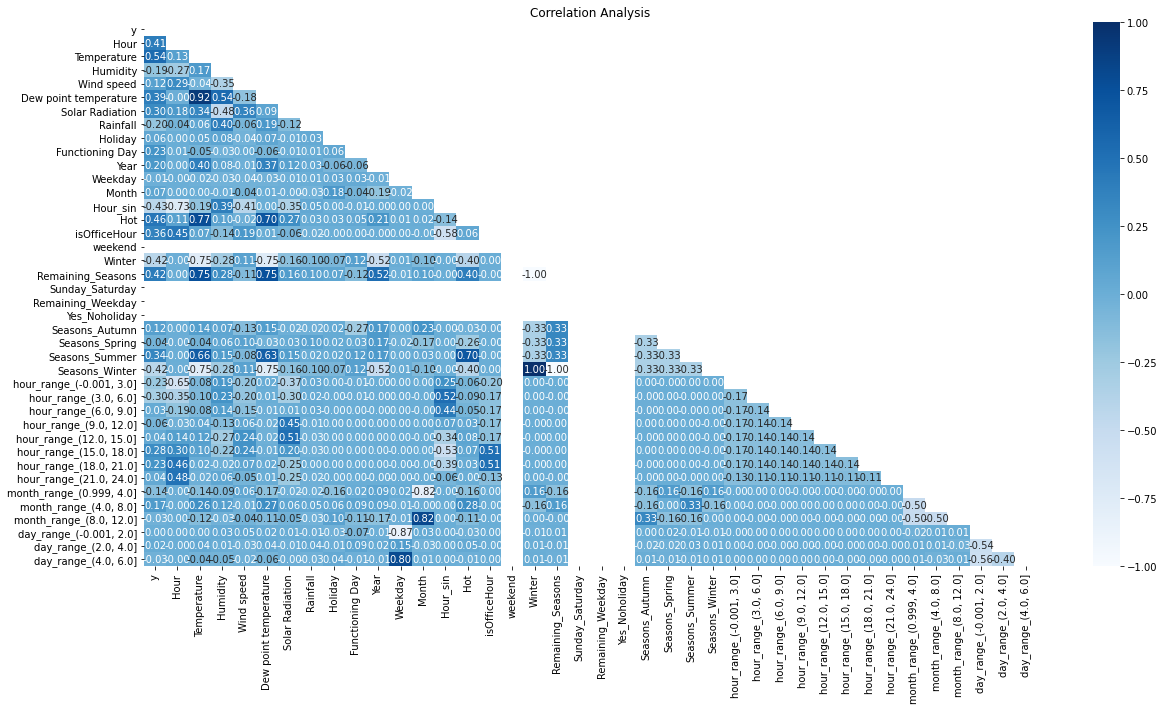

In [17]:
corr_matrix = train_df.corr()
mask = np.triu(np.ones_like(corr_matrix,dtype = bool))
plt.figure(figsize = (20,10))
sns.heatmap(corr_matrix, fmt = '0.2f', cmap = 'Blues', mask = mask, annot = True)
plt.title("Correlation Analysis");

In [18]:
train_df.columns

Index(['y', 'Hour', 'Temperature', 'Humidity', 'Wind speed',
       'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Holiday',
       'Functioning Day', 'Year', 'Weekday', 'Month', 'Hour_sin', 'Hot',
       'isOfficeHour', 'weekend', 'Winter', 'Remaining_Seasons',
       'Sunday_Saturday', 'Remaining_Weekday', 'Yes_Noholiday',
       'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'hour_range_(-0.001, 3.0]', 'hour_range_(3.0, 6.0]',
       'hour_range_(6.0, 9.0]', 'hour_range_(9.0, 12.0]',
       'hour_range_(12.0, 15.0]', 'hour_range_(15.0, 18.0]',
       'hour_range_(18.0, 21.0]', 'hour_range_(21.0, 24.0]',
       'month_range_(0.999, 4.0]', 'month_range_(4.0, 8.0]',
       'month_range_(8.0, 12.0]', 'day_range_(-0.001, 2.0]',
       'day_range_(2.0, 4.0]', 'day_range_(4.0, 6.0]'],
      dtype='object')

# Spliting Data

In [19]:
features= train_df.drop(columns = ['y'])
target = np.log1p(train_df['y'])

from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size = 0.15, shuffle = True, random_state = 42)

In [20]:
# X_train_with_Y=train_df[train_df["day"]<=15]
# X_Valid_with_Y=train_df[train_df["day"]>15]

# X_train=X_train_with_Y.drop(columns=["Y"])
# X_Val=X_Valid_with_Y.drop(columns=["Y"])

# y_train=np.log1p(pd.DataFrame(X_train_with_Y["Y"]))
# y_val=np.log1p(pd.DataFrame(X_Valid_with_Y["Y"]))

# Training Some Model

In [21]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer

#GB_model=HistGradientBoostingRegressor(n_estimators=200,max_depth=5)
GB_model = GradientBoostingRegressor(n_estimators = 200, max_depth =5,max_leaf_nodes=60,loss="huber",random_state=0)
GB_model.fit(X_train, y_train)

GradientBoostingRegressor(loss='huber', max_depth=5, max_leaf_nodes=60,
                          n_estimators=200, random_state=0)

<BarContainer object of 39 artists>

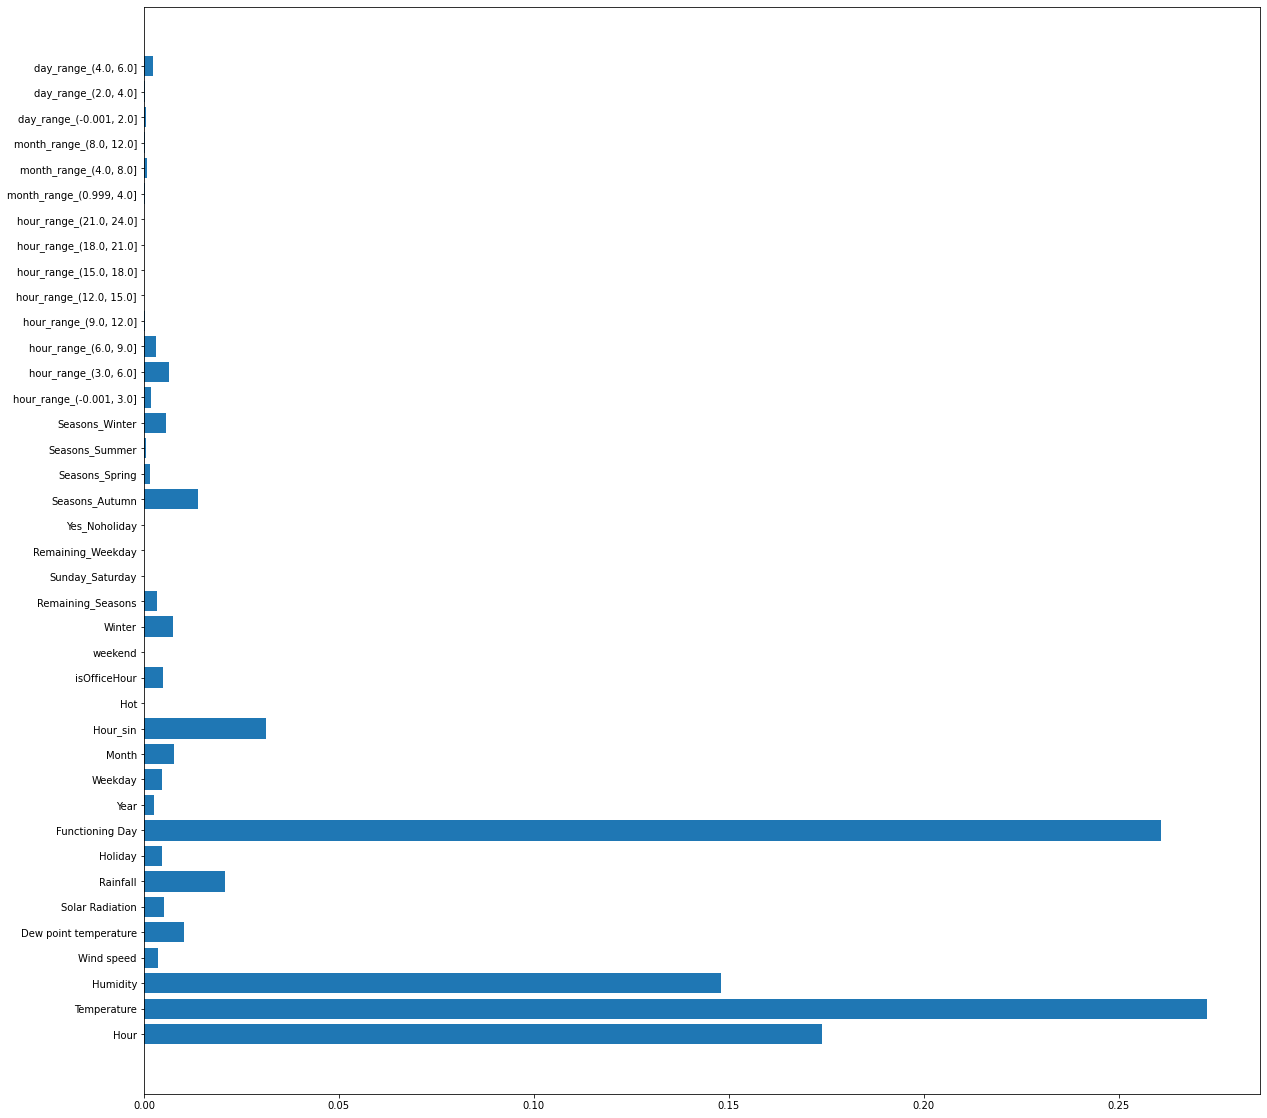

In [22]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
plt.barh( X_train.columns,GB_model.feature_importances_)


In [23]:
def print_metrics(y_train_pred, y_val_pred, model_name) :
    print('============' + model_name + '============' )
    print('R2_Score for Training Data Is : ', r2_score(np.expm1(y_train), np.expm1(y_train_pred)))
    print('R2_Score For Validation Data Is : ', r2_score(np.expm1(y_val), np.expm1(y_val_pred)))
    print('Square Root Of Mean Squared Log Error For Training Data : ', np.sqrt(mean_squared_log_error(np.round(np.expm1(y_train)), np.round(np.expm1(y_train_pred)))))
    print('Square Root Of Mean Squared Log Error For Validation Data : ', np.sqrt(mean_squared_log_error(np.round(np.expm1(y_val)), np.round(np.expm1(y_val_pred)))))
    print('\n')

In [24]:
GB_train_pred = GB_model.predict(X_train)
GB_val_pred = GB_model.predict(X_val)
# Gradient Boosting Scores
print_metrics(GB_train_pred, GB_val_pred, 'Gradient Boosting Regressor')

============Gradient Boosting Regressor============
R2_Score for Training Data Is :  0.9422091221134676
R2_Score For Validation Data Is :  0.884969361068376
Square Root Of Mean Squared Log Error For Training Data :  0.28158054822021444
Square Root Of Mean Squared Log Error For Validation Data :  0.37715495178150243




In [25]:

y_test_1 = GB_model.predict(X_test)

test_df['y'] = np.round(np.expm1(y_test_1))

In [26]:
test_df[['ID', 'y']].to_csv('submission.csv', index = False)